# Freesurfer segmentation using bash cell magic with input parameters


BMED360-2021 `freesurfer-segmentation-bash.ipynb`  (**assuming Linux or MacOS with FS 7.1.1 installed**)

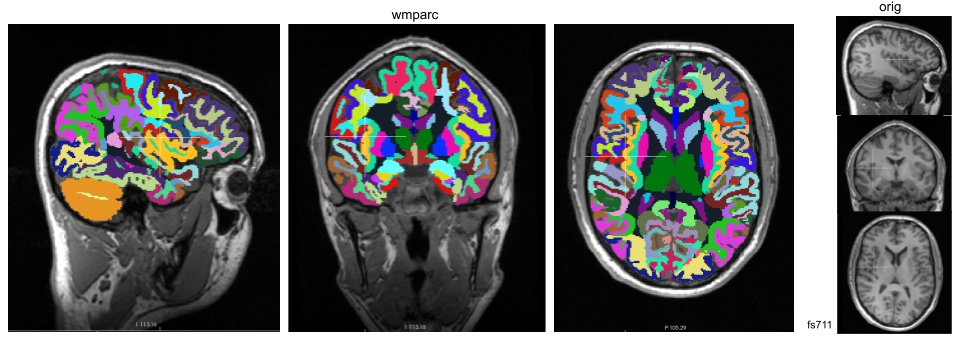

In [2]:
from IPython.display import Image
Image("assets/sub_102_tp1_mri_orig_wmparc.png")

In [3]:
import os
from os.path import expanduser, join, basename, split
home = expanduser('~') # To make path to local home directory
cwd = os.getcwd()
import glob
from pathlib import Path

In [4]:
#Assuming tcsh is installed
# e.g. sudo apt-get install tcsh
RECON_ALL = '/usr/local/freesurfer/bin/recon-all'
print(os.popen(RECON_ALL).read())


USAGE: recon-all

 Required Arguments:
   -subjid <subjid>
   -<process directive>

 Fully-Automated Directive:
  -all           : performs all stages of cortical reconstruction
  -autorecon-all : same as -all

 Manual-Intervention Workflow Directives:
  -autorecon1    : process stages 1-5 (see below)
  -autorecon2    : process stages 6-23
                   after autorecon2, check white surfaces:
                     a. if wm edit was required, then run -autorecon2-wm
                     b. if control points added, then run -autorecon2-cp
                     c. proceed to run -autorecon3
  -autorecon2-cp : process stages 12-23 (uses -f w/ mri_normalize, -keep w/ mri_seg)
  -autorecon2-wm : process stages 15-23
  -autorecon2-inflate1 : 6-18
  -autorecon2-perhemi : tess, sm1, inf1, q, fix, sm2, inf2, finalsurf, ribbon
  -autorecon3    : process stages 24-34
                     if edits made to correct pial, then run -autorecon-pial
  -hemi ?h       : just do lh or rh (default is to 

### Some preparations before running Freesurfer

In [5]:
fs711_home = '/usr/local/freesurfer'
working_dir = join(cwd, 'data')
my_fs711_dir = '%s/fs711_subjects' % (working_dir)
my_bids_dir = '%s/bids_bg_bmed360' % (working_dir)

In [6]:
if not os.path.exists(my_fs711_dir):
    os.makedirs(my_fs711_dir)
else:
    print('subdirectory fs711_subjects already exists')

subdirectory fs711_subjects already exists


#### Get a list of all T1w files from BIDS directory and renaming

In [8]:
T1_files = []
subj_names = []
for file_path in Path(my_bids_dir).glob('**/*ses-*_T1w.nii.gz'):
    T1_files.append(str(file_path))
    subj_names.append(str(file_path.name[:-11])) # truncate end of filename:  _T1w.nii.gz (= 11 characters)
all_T1_files = sorted(T1_files)
all_subj_names = sorted(subj_names)

print('\n', [os.path.basename(fn) for fn in  all_T1_files])
all_subj_names


 ['sub-102_ses-1_T1w.nii.gz', 'sub-102_ses-2_T1w.nii.gz', 'sub-103_ses-1_T1w.nii.gz', 'sub-103_ses-2_T1w.nii.gz', 'sub-111_ses-1_T1w.nii.gz', 'sub-111_ses-2_T1w.nii.gz', 'sub-123_ses-1_T1w.nii.gz', 'sub-123_ses-2_T1w.nii.gz']


['sub-102_ses-1',
 'sub-102_ses-2',
 'sub-103_ses-1',
 'sub-103_ses-2',
 'sub-111_ses-1',
 'sub-111_ses-2',
 'sub-123_ses-1',
 'sub-123_ses-2']

In [9]:
# renamimg using list comprehension twice
lst1 = [sub.replace('-', '_') for sub in all_subj_names]
all_subjects = [sub.replace('ses_', 'tp') for sub in lst1]
all_subjects

['sub_102_tp1',
 'sub_102_tp2',
 'sub_103_tp1',
 'sub_103_tp2',
 'sub_111_tp1',
 'sub_111_tp2',
 'sub_123_tp1',
 'sub_123_tp2']

### Make lists of all subjects and all their original T1w files to be segmented

In [10]:
lst = all_subjects
lstfn = all_T1_files
lstfs711 = [my_fs711_dir]
#print(lst)
#print(lstfn)
#print(lstfs711)

#### Illustration of using `bash` magic with string input for Freesurfer recon-all, cfr.
https://stackoverflow.com/questions/19579546/can-i-access-python-variables-within-a-bash-or-script-ipython-notebook-c

In [53]:
%%bash -s './data/fs711_subjects' 'sub_102_tp1' 'sub_102_tp2' 'sub_103_tp1' 'sub_103_tp2'

for i in $1 $2 $3 $4 $5
do
echo $i
done

./data/fs711_subjects
sub_102_tp1
sub_102_tp2
sub_103_tp1
sub_103_tp2


### To run Freesurfer de novo, uncomment (and adjust the inputs in) the first line

In [55]:
%%bash -s  '/usr/local/freesurfer' "{" ".join(lstfs711)}" "{" ".join(lst)}" "{" ".join(lstfn)}"

# Input:
# $1: Freesurfer home directory, e.g. '/usr/local/freesurfer' 
# $2: subjects home directory, e.g. './data/fs711_subjects'
# $3: list of subjects to run, e.g. ['sub_101_tp1', 'sub_101_tp2']
# $4: list of original T1w-files (to copy), according to the list of subjects, e.g.
#       ['./data/bids_bg_bmed360/sub-101/ses-1/anat/sub-101_ses-1_T1w.nii.gz',
#        './data/bids_bg_bmed360/sub-101/ses-2/anat/sub-101_ses-2_T1w.nii.gz']
 
# Output:
#   Freesurfer tree for each of the subjects in the given list

echo $1
echo $2

FREESURFER_HOME=${1}; export FREESURFER_HOME
PATH=${FREESURFER_HOME}/bin:${PATH}; export PATH
SUBJECTS_DIR=${2}; export SUBJECTS_DIR
FSLDIR=/usr/local/fsl; export FSLDIR
PATH=${FSLDIR}/bin:${PATH}; export PATH
. ${FSLDIR}/etc/fslconf/fsl.sh
source ${FREESURFER_HOME}/SetUpFreeSurfer.sh


# PREPARE Data
cd $SUBJECTS_DIR

ii=0
counter=0

for i in $3
do
  echo $i
  # Make FreeSurfer tree for this subject
  mksubjdirs $i
  cd $i
  cd mri/orig
  mkdir 001

  for k in $4
  do
   if [ $counter == $ii ]
   then
      echo $k
      # Copy the proper DICOM or NIFTI data to the FS tree
      cp -r $k 001/T1_orig.nii.gz
      # Convert from NIFTI to MGZ
      mri_convert -it nii -ot mgz 001/T1_orig.nii.gz 001.mgz
    
      # Start FreeSurfer processing
      cd $SUBJECTS_DIR
      recon-all -s $i -all >& /dev/null &
      echo '#recon-all -s $i -all >& /dev/null &'
    
   fi
   ((counter++))
  done
  ((ii++))
  counter=0

done


/usr/local/freesurfer
/home/arvid/GitHub/computational-medicine/BMED360-2021/Lab3-diffusion-MRI/data/fs711_subjects
sub_102_tp1
 
REMEMBER to do a 'chgrp -R r_group' for the right group if needed.
    All directories where just created as group writable.
    Use the 'id' command to get a list of your groups.
 
Creation of subject directory complete.
See recon-all -help for more info on how to proceed.
 
/home/arvid/GitHub/computational-medicine/BMED360-2021/Lab3-diffusion-MRI/data/bids_bg_bmed360/sub-102/ses-1/anat/sub-102_ses-1_T1w.nii.gz
mri_convert -it nii -ot mgz 001/T1_orig.nii.gz 001.mgz 
reading from 001/T1_orig.nii.gz...
TR=7.76, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-0.999602, 0.0108075, 0.0260588)
j_ras = (0.0108036, 0.999942, -0)
k_ras = (0.0260627, -0.000274657, 0.99966)
writing to 001.mgz...
#recon-all -s $i -all >& /dev/null &
sub_102_tp2
 
REMEMBER to do a 'chgrp -R r_group' for the right group if needed.
    All directories where just created as group writable.
   

`This will take a long time ......` monitor with 'htop' and check  `.../scripts/recon-all.log` occasionally